In [2]:
from common_func import *
if type_of_script() == 'jupyter': from tqdm.notebook import tqdm
else: from tqdm import tqdm
    
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import colormaps
from matplotlib.colors import Normalize
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D, proj3d
#import cmasher as cmr

import numpy as np
import os, glob, atexit, signal, time, warnings, argparse, subprocess

from rur.fortranfile import FortranFile
from rur import uri, uhmi, painter, drawer
from rur.sci.photometry import measure_luminosity
from rur.sci.geometry import get_angles, euler_angle
from rur.utool import rotate_data
from scipy.ndimage import gaussian_filter
uri.timer.verbose=1

from icl_IO import mode2repo, pklsave, pklload
from icl_tool import *
from icl_numba import large_isin, large_isind, isin
from icl_draw import drawsnap, add_scalebar, addtext, MakeSub_nolabel, label_to_in, fancy_axis, circle

from importlib import reload
from copy import deepcopy
from multiprocessing import Pool, shared_memory, Value

# Numerical Simulation

In [3]:
nh1 = uri.RamsesSnapshot("/storage6/NewHorizon", 1026, mode='nh')
nh1s = uri.TimeSeries(nh1)
nh1s.read_iout_avail()
nh1s.iout_avail['iout'][0]

nh2 = uri.RamsesSnapshot("/storage7/NH2", 797, mode='nh2')
nh2s = uri.TimeSeries(nh2)
nh2s.read_iout_avail()
nh2s.iout_avail['iout'][0]

gals1 = uhmi.HaloMaker.load(nh1, galaxy=True)
gals2 = uhmi.HaloMaker.load(nh2, galaxy=True)
hals1 = uhmi.HaloMaker.load(nh1, galaxy=False)
hals2 = uhmi.HaloMaker.load(nh2, galaxy=False)
phals1 = hals1[hals1['mcontam']==0]
phals2 = hals2[hals2['mcontam']==0]
ghals1 = hals1[hals1['mcontam']<hals1['m']]
ghals2 = hals2[hals2['mcontam']<hals2['m']]
lhals1 = hals1[hals1['mcontam']==hals1['m']]
lhals2 = hals2[hals2['mcontam']==hals2['m']]

[Output 01026] Age (Gyr) : 11.624 / 13.741, z = 0.17149 (a = 0.8536)
[Output 00797] Age (Gyr) : 11.623 / 13.741, z = 0.17158 (a = 0.8536)


## Halo Mass Function

In [23]:
baldry = np.genfromtxt("GSMF_baldry.csv", comments="#", delimiter=',')
mask = baldry[:,0] < 11.35
baldry = baldry[mask]
baldry[0]

array([ 7.10327704, -1.75023139])

In [24]:
li = np.genfromtxt("GSMF_li.csv", comments="#", delimiter=',')
mask = li[:,0] < 11.35
li = li[mask]
li[-1]

array([11.3484 , -3.77214])

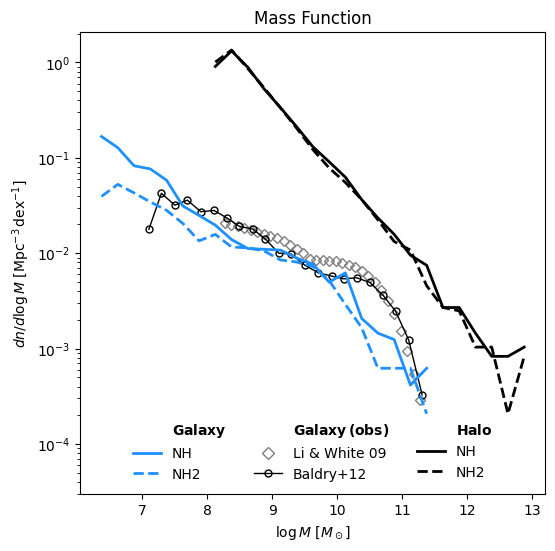

In [47]:
from matplotlib.lines import Line2D
hdex = 0.25
hmin = 8; hmax=13
hbins = np.arange(hmin, hmax+hdex, hdex)
hx = (hbins[:-1] + hbins[1:]) / 2

fig, ax = plt.subplots(figsize=(6, 6))

# ax.scatter(obs[:,0], 10**obs[:,1], marker='o', ec='grey', fc='none', s=20)
ax.plot(li[:,0][::20], 10**li[:,1][::20],lw=0, color='grey', marker='D', mec='grey', mfc='none', ms=5, mew=1, label='Li & White 09', zorder=-1)
ax.plot(baldry[:,0], 10**baldry[:,1],lw=1, color='k', marker='o', mec='k', mfc='none', ms=5, mew=1, label='Baldry+12')


hmf1 = np.histogram(np.log10(ghals1['m']), bins=hbins)[0] # number
volume1 = sphere(10/nh1.h/nh1.aexp) # (Mpc)^3
hmf1 = hmf1 / volume1 / (hbins[1] - hbins[0]) # number density
hmf2 = np.histogram(np.log10(ghals2['m']), bins=hbins)[0] # number
volume2 = sphere(10/nh2.h/nh2.aexp) # (Mpc)^3
hmf2 = hmf2 / volume2 / (hbins[1] - hbins[0]) # number density
ax.plot(hx, hmf1, lw=2, color='k', label='NH Halo', ls='-')
ax.plot(hx, hmf2, lw=2, color='k', label='NH2 Halo', ls='--')


ax.set_yscale('log')
ax.set_xlabel(r'$\log M_h\ [M_\odot]$')


gdex = 0.25
smin=6.25; smax = 11.5
gbins = np.arange(smin, smax+gdex, gdex)
gx = (gbins[:-1] + gbins[1:]) / 2

gmf1 = np.histogram(np.log10(gals1['m']), bins=gbins)[0] # number
volume1 = sphere(10/nh1.h/nh1.aexp) # (Mpc)^3
gmf1 = gmf1 / volume1 / (gbins[1] - gbins[0]) # number density
gmf2 = np.histogram(np.log10(gals2['m']), bins=gbins)[0] # number
volume2 = sphere(10/nh2.h/nh2.aexp) # (Mpc)^3
gmf2 = gmf2 / volume2 / (gbins[1] - gbins[0]) # number density
ax.plot(gx, gmf1, lw=2, label='NH Galaxy', color='dodgerblue', ls='-')
ax.plot(gx, gmf2, lw=2, label='NH2 Galaxy', color='dodgerblue', ls='--')

ax.set_ylabel(r'$dn/d\log M\ [\rm{ Mpc^{-3}\,dex^{-1}}]$')
ax.set_xlabel(r'$\log M\ [M_\odot]$')
ax.set_title("Mass Function")

legend_elements = [
    Line2D([0],[0], marker='.',color='none', markeredgecolor='k', markerfacecolor='none', markersize=0, label=r'$\mathbf{Galaxy}$'),
    Line2D([0],[0], lw=2, ls='-',color='dodgerblue', label='NH'),
    Line2D([0],[0], lw=2, ls='--',color='dodgerblue', label='NH2'),
    Line2D([0],[0], marker='.',color='none', markeredgecolor='k', markerfacecolor='none', markersize=0, label=r'$\mathbf{Galaxy\,(obs)}$'),
    Line2D([0],[0], lw=0, color='grey', marker='D', mec='grey', mfc='none', label='Li & White 09'),
    Line2D([0],[0], lw=1, color='k', marker='o', mec='k', mfc='none', ms=5, mew=1, label='Baldry+12'),
    Line2D([0],[0], marker='.',color='none', markeredgecolor='k', markerfacecolor='none', markersize=0, label=r'$\mathbf{Halo}$'),
    Line2D([0],[0], lw=2, ls='-',color='k', label='NH'),
    Line2D([0],[0], lw=2, ls='--',color='k', label='NH2'),
    # Line2D([0],[0], marker='*',color='none', markeredgecolor='k', markerfacecolor='none', markersize=8, label=r'  $M_{star}$'),
    # Line2D([0],[0], marker='H',color='none', markeredgecolor='k', markerfacecolor='none', markersize=8, label=r'  $M_{cold}$'),
    # Line2D([0],[0], marker='.',color='none', markeredgecolor='k', markerfacecolor='none', markersize=0, label=r'$\mathcal{Has\ Cold\ Gas?}$'),
    # Line2D([0],[0], marker='o',color='none', markerfacecolor='none', markeredgecolor='deepskyblue', markersize=8, label='  Yes'),
    # Line2D([0],[0], marker='o',color='none', markerfacecolor='none', markeredgecolor='k', markersize=8, label='  No'),
]
ax.set_ylim(3e-5,)

plt.subplots_adjust(hspace=0, wspace=0)
ax.legend(handles=legend_elements, loc='lower center', ncols=3, frameon=False)
# ax.legend()
plt.savefig("00_HMF.png", dpi=400, facecolor='w', bbox_inches='tight', pad_inches=0.1)
plt.show()

# LSS Map

In [34]:
x1 = min(np.min(phals1['x']-phals1['r']), np.min(phals2['x']-phals2['r']))
x2 = max(np.max(phals1['x']+phals1['r']), np.max(phals2['x']+phals2['r']))
y1 = min(np.min(phals1['y']-phals1['r']), np.min(phals2['y']-phals2['r']))
y2 = max(np.max(phals1['y']+phals1['r']), np.max(phals2['y']+phals2['r']))
z1 = min(np.min(phals1['z']-phals1['r']), np.min(phals2['z']-phals2['r']))
z2 = max(np.max(phals1['z']+phals1['r']), np.max(phals2['z']+phals2['r']))

ibox = np.array([[x1, x2], [y1, y2], [z1, z2]])

nh1.box = ibox; nh2.box = ibox
nh1.get_part(pname='dm', nthread=32, target_fields=['x','y','z','m'])
nh2.get_part(pname='dm', nthread=32, target_fields=['x','y','z','m'])

Searching for extra files...
CPU list already satisfied.
Domain Slicing...
Done (4.362s).
Masking particles... 107844909 / 126480901 (0.8527)
Done (4.150s).
Searching for extra files...
CPU list already satisfied.
Masking particles... 119614141 / 138012792 (0.8667)
Done (4.163s).


Particle({'table': array([(0.49742989, 0.47326397, 0.42158906, 6.20425193e-09,   1),
       (0.49746303, 0.47295263, 0.42125344, 6.20425193e-09,   1),
       (0.49649141, 0.47827065, 0.42148553, 6.20425193e-09,   1), ...,
       (0.51979367, 0.49939407, 0.46069333, 1.21176795e-11, 480),
       (0.5198974 , 0.4994837 , 0.46076534, 1.21176795e-11, 480),
       (0.51986324, 0.49951167, 0.46078457, 1.21176795e-11, 480)],
      dtype=[('x', '<f8'), ('y', '<f8'), ('z', '<f8'), ('m', '<f8'), ('cpu', '<i4')]), 'snap': <rur.uri.RamsesSnapshot object at 0x7fc0a2e1eb60>, 'extra_fields': {'pos': <function custom_extra_fields.<locals>.<lambda> at 0x7fbf72881d80>, 'vel': <function custom_extra_fields.<locals>.<lambda> at 0x7fbf72883ac0>, 'age': <function custom_extra_fields.<locals>.<lambda> at 0x7fc079de5630>, 'aform': <function custom_extra_fields.<locals>.<lambda> at 0x7fc079de5510>, 'zform': <function custom_extra_fields.<locals>.<lambda> at 0x7fc079de5870>, 'dx': <function custom_extra_fields.<

In [35]:
import cmasher as cmr

In [38]:
nh1img = painter.partmap(nh1.part, box=nh1.box, shape=1000, weights=nh1.part['m'])
nh2img = painter.partmap(nh2.part, box=nh2.box, shape=1000, weights=nh2.part['m'])
vmax = max(np.max(nh1img), np.max(nh2img))
vmin = vmax / 1e3


Computing particle map of 107844909 particles... 
Done (10.559s).
Computing particle map of 119614141 particles... 
Done (12.183s).


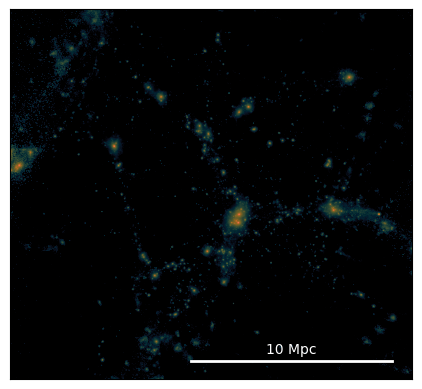

In [44]:
fig, ax = fancy_axis()
painter.draw_image(nh1img, extent=nh1.box[:2].flatten(),ax=ax, cmap=cmr.dusk, vmax=vmax, vmin=vmin)
add_scalebar(ax, nh1.unit_l)
plt.savefig("00_LSS_NH.png", dpi=400, facecolor='w', bbox_inches='tight', pad_inches=0)
plt.show()
plt.close()

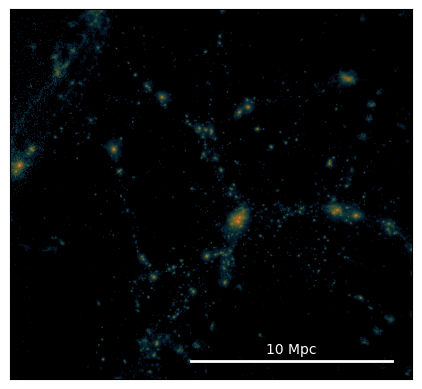

In [45]:
fig, ax = fancy_axis()
painter.draw_image(nh2img, extent=nh2.box[:2].flatten(),ax=ax, cmap=cmr.dusk, vmax=vmax, vmin=vmin)
add_scalebar(ax, nh2.unit_l)
plt.savefig("00_LSS_NH2.png", dpi=400, facecolor='w', bbox_inches='tight', pad_inches=0)
plt.show()
plt.close()

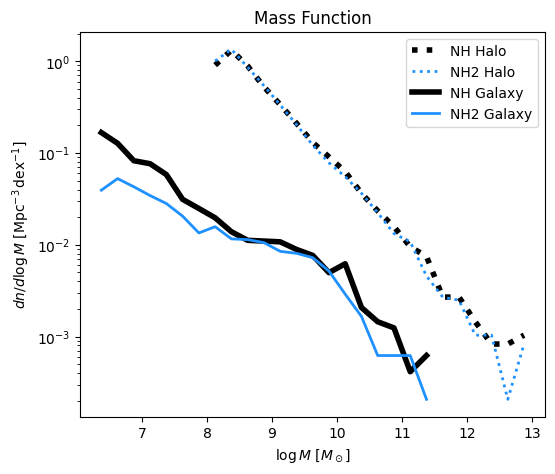